In [1]:
import setup_lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from typing import List
from datasets.heart_dataset import HeartDataset
from common.plot import plot_pca_2d, plot_tsne_2d

Using TensorFlow backend.


https://www.kaggle.com/ronitf/heart-disease-uci

Attribute Information: 
> 1. age 
> 2. sex 
> 3. cp - chest pain type (4 values) 
> 4. resting blood pressure 
> 5. serum cholestoral in mg/dl 
> 6. fasting blood sugar > 120 mg/dl
> 7. restecg - resting electrocardiographic results (values 0,1,2)
> 8. thalach - maximum heart rate achieved 
> 9. exercise induced angina 
> 10. oldpeak = ST depression induced by exercise relative to rest 
> 11. slope - the slope of the peak exercise ST segment 
> 12. number of major vessels (0-3) colored by flourosopy 
> 13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [2]:
np.random.seed(25)

In [3]:
dataset = HeartDataset()
df = dataset.data

Initializing dataset "file:/home/liu/.sync/Dropbox/learn/machine-learning/_apps/data/heart" and caching it in "/home/liu/.keras/heart"


In [4]:
print(dataset.features_cols)
print(dataset.target_col)

class_names = ['Не хворий', 'Хворий']

df.head()

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
target


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


##### Target

In [5]:
df[dataset.target_col].value_counts()

1    165
0    138
Name: target, dtype: int64

##### Візуалізація данних

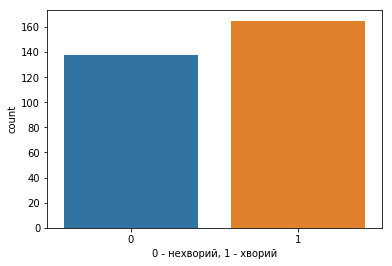

In [6]:
sns.countplot(x=dataset.target_col, data=df)
plt.xlabel("0 - нехворий, 1 - хворий")
plt.show()

##### Sex plot

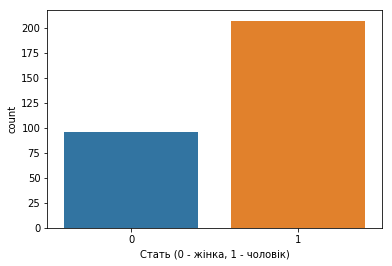

In [7]:
sns.countplot(x='sex', data=df)
plt.xlabel("Стать (0 - жінка, 1 - чоловік)")
plt.show()

##### Частота за віком

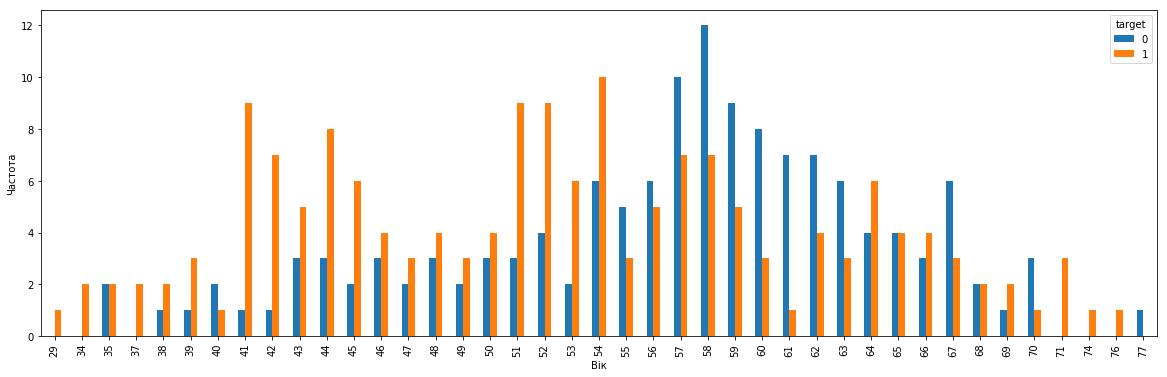

In [8]:
pd.crosstab(df['age'], df[dataset.target_col]).plot(kind="bar",figsize=(20,6))
plt.xlabel('Вік')
plt.ylabel('Частота')
plt.show()

##### Графік залежності максимальної частоти биття сердця від віку 


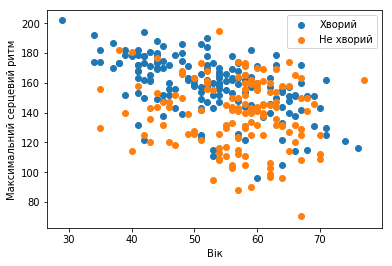

In [9]:
target_1 = df[dataset.target_col] == 1
target_0 = df[dataset.target_col] == 0
plt.scatter(x=df["age"][target_1], y=df["thalach"][target_1])
plt.scatter(x=df["age"][target_0], y=df["thalach"][target_0])
plt.legend(["Хворий", "Не хворий"])
plt.xlabel("Вік")
plt.ylabel("Максимальний серцевий ритм")
plt.show()

##### Підготовка до аналізу данних


In [10]:
def prepair_categorical_features(df: pd.DataFrame, columns: List[str]):
    for col in columns:
        print(f"{col} values = ", sorted(df[col].unique()))

    dummy_cols = [pd.get_dummies(df[col], prefix=col) for col in columns]
    result = pd.concat([df, *dummy_cols], axis=1)
    result = result.drop(columns=columns)
    return result

In [11]:
df = prepair_categorical_features(df, ['cp', 'thal', 'slope'])
df.head()

cp values =  [0, 1, 2, 3]
thal values =  [0, 1, 2, 3]
slope values =  [0, 1, 2]


,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,0,150,0,2.3,0,...,0,0,1,0,1,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3.5,0,...,0,1,0,0,0,1,0,1,0,0
2,41,0,130,204,0,0,172,0,1.4,0,...,1,0,0,0,0,1,0,0,0,1
3,56,1,120,236,0,1,178,0,0.8,0,...,1,0,0,0,0,1,0,0,0,1
4,57,0,120,354,0,1,163,1,0.6,0,...,0,0,0,0,0,1,0,0,0,1


In [12]:
x_df = df.drop(columns=[dataset.target_col])
y = df[dataset.target_col].values

##### Нормалізація даних

In [13]:
x_df.values[:3]

array([[ 63. ,   1. , 145. , 233. ,   1. ,   0. , 150. ,   0. ,   2.3,
          0. ,   0. ,   0. ,   0. ,   1. ,   0. ,   1. ,   0. ,   0. ,
          1. ,   0. ,   0. ],
       [ 37. ,   1. , 130. , 250. ,   0. ,   1. , 187. ,   0. ,   3.5,
          0. ,   0. ,   0. ,   1. ,   0. ,   0. ,   0. ,   1. ,   0. ,
          1. ,   0. ,   0. ],
       [ 41. ,   0. , 130. , 204. ,   0. ,   0. , 172. ,   0. ,   1.4,
          0. ,   0. ,   1. ,   0. ,   0. ,   0. ,   0. ,   1. ,   0. ,
          0. ,   0. ,   1. ]])

In [14]:
x = ((x_df - np.min(x_df)) / (np.max(x_df) - np.min(x_df))).values

In [15]:
print(x[:3])

[[0.70833333 1.         0.48113208 0.24429224 1.         0.
  0.60305344 0.         0.37096774 0.         0.         0.
  0.         1.         0.         1.         0.         0.
  1.         0.         0.        ]
 [0.16666667 1.         0.33962264 0.28310502 0.         0.5
  0.88549618 0.         0.56451613 0.         0.         0.
  1.         0.         0.         0.         1.         0.
  1.         0.         0.        ]
 [0.25       0.         0.33962264 0.17808219 0.         0.
  0.77099237 0.         0.22580645 0.         0.         1.
  0.         0.         0.         0.         1.         0.
  0.         0.         1.        ]]


##### Тренування і оцінювання

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.45, random_state=25)

In [17]:
print(x_train.shape)
print(y_train.shape)
print(sum(y_test == 0), sum(y_test == 1))

(166, 21)
(166,)
63 74


*Логістична регресія з графіками PCA, t-SNE*

Точність тестування 84.67%
              precision    recall  f1-score   support

   Не хворий       0.88      0.78      0.82        63
      Хворий       0.83      0.91      0.86        74

   micro avg       0.85      0.85      0.85       137
   macro avg       0.85      0.84      0.84       137
weighted avg       0.85      0.85      0.85       137



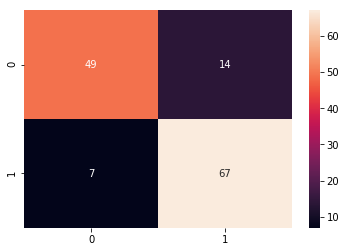

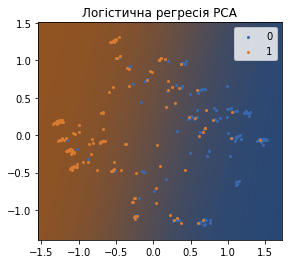

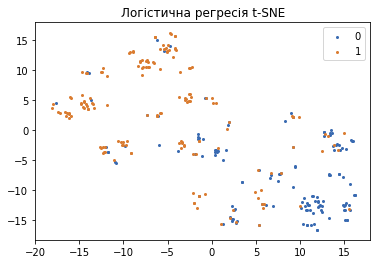

In [18]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(x_train, y_train)
print(f"Точність тестування {lr.score(x_test, y_test) * 100:.2f}%")
print(classification_report(y_test, lr.predict(x_test), target_names=class_names))

cm_lr = confusion_matrix(y_test, lr.predict(x_test))
sns.heatmap(cm_lr, annot=True)
plt.show()

plot_pca_2d(x, y, model=lr, title=f"Логістична регресія PCA")
plot_tsne_2d(x, y, title=f"Логістична регресія t-SNE")

*KNN (k найближчих сусідів)*

Best: 18-NN Score: 86.86%
              precision    recall  f1-score   support

   Не хворий       0.85      0.87      0.86        63
      Хворий       0.89      0.86      0.88        74

   micro avg       0.87      0.87      0.87       137
   macro avg       0.87      0.87      0.87       137
weighted avg       0.87      0.87      0.87       137



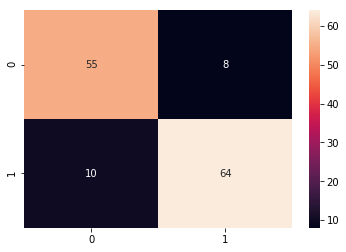

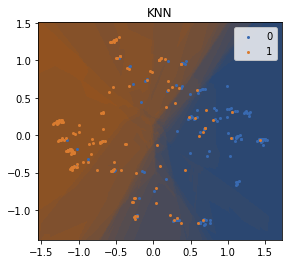

In [19]:
k = None
knn = None
for k_new in range(1, 30):
    knn_new = KNeighborsClassifier(n_neighbors=k_new)
    knn_new.fit(x_train, y_train)
    
    if knn is None or knn.score(x_test, y_test) < knn_new.score(x_test, y_test):
        k = k_new
        knn = knn_new

print(f"Best: {k}-NN Score: {knn.score(x_test, y_test) * 100:.2f}%")
print(classification_report(y_test, knn.predict(x_test), target_names=class_names))

cm_knn = confusion_matrix(y_test, knn.predict(x_test))
sns.heatmap(cm_knn, annot=True)
plt.show()

plot_pca_2d(x, y, model=knn, title=f"KNN")